In [60]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing import timeseries_dataset_from_array
# from google.colab import drive
# drive.mount('/content/drive')
path = 'ETH_1min.csv'


class DataPreprocess:
    def __init__(self):
        pass

    def load_data(self, path):
        df = pd.read_csv(path)
        df.drop("Unnamed: 0", inplace=True, axis = 1)
        #df.drop("system_time", inplace=True, axis = 1)
        return df

    def get_bid_levels(self, df, bid_levels):
        df_tmp = pd.DataFrame()
        df_tmp['time'] = df['system_time']
        df_tmp['midpoint'] = df['midpoint']

        # Filter ask and bid volume columns
        ask_cols = [f'asks_limit_notional_{i}' for i in range(bid_levels)]
        bid_cols = [f'bids_limit_notional_{i}' for i in range(bid_levels)]
        ask_cols = [col for col in ask_cols if col in df.columns]
        bid_cols = [col for col in bid_cols if col in df.columns]

        # Assign ask and bid volumes
        for lvls in range(len(ask_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_volume{lvls}'] = df[ask_cols[lvls]]
        for lvls in range(len(bid_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_volume{lvls}'] = df[bid_cols[lvls]]

        # Filter ask and bid distance columns
        ask_distance_cols = [f'asks_distance_{i}' for i in range(bid_levels)]
        bid_distance_cols = [f'bids_distance_{i}' for i in range(bid_levels)]
        ask_distance_cols = [col for col in ask_distance_cols if col in df.columns]
        bid_distance_cols = [col for col in bid_distance_cols if col in df.columns]

        # Assign ask and bid prices
        for lvls in range(len(ask_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[ask_distance_cols[lvls]])
        for lvls in range(len(bid_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[bid_distance_cols[lvls]])
        return df_tmp

In [61]:
dp = DataPreprocess()

df = dp.load_data(path)

num_levels = 10
df = dp.get_bid_levels(df, num_levels)

In [62]:
df.head()

,time,midpoint,ask_volume0,ask_volume1,ask_volume2,ask_volume3,ask_volume4,ask_volume5,ask_volume6,ask_volume7,...,bid_price0,bid_price1,bid_price2,bid_price3,bid_price4,bid_price5,bid_price6,bid_price7,bid_price8,bid_price9
0,2021-04-07 11:33:49.861733+00:00,1965.845,20005.570312,3234.250000,2.000531e+04,4350.029785,5839.970215,20005.439453,3874.320068,731.830017,...,1965.84,1965.54,1965.53,1965.34,1965.33,1965.30,1965.01,1965.00,1964.95,1964.85
1,2021-04-07 11:34:49.861733+00:00,1969.645,36921.578125,29840.800781,1.003755e+06,3873.060059,20216.859375,20009.779297,20004.830078,733.619995,...,1969.32,1969.27,1969.25,1969.24,1969.22,1969.14,1969.12,1969.11,1969.06,1969.05
2,2021-04-07 11:35:49.861733+00:00,1975.595,13438.839844,3873.080078,6.975460e+03,21856.339844,28646.380859,3873.739990,26095.470703,743.140015,...,1975.45,1975.44,1975.41,1975.40,1975.21,1975.06,1975.04,1974.96,1974.94,1974.57
3,2021-04-07 11:36:49.861733+00:00,1969.335,2028.510010,31570.119141,2.204419e+04,4873.629883,19998.630859,7077.069824,985.219971,20004.689453,...,1969.24,1969.01,1969.00,1968.96,1968.79,1968.59,1968.58,1968.48,1968.47,1968.46
4,2021-04-07 11:37:49.861733+00:00,1970.965,1163.010010,1163.020020,3.769630e+03,21908.570312,4873.000000,77911.609375,79081.539062,50146.808594,...,1970.72,1970.71,1970.57,1970.48,1970.45,1970.38,1970.34,1970.07,1969.97,1969.96


In [63]:
df = df.drop(columns=["time"])

In [64]:
from tensorflow.keras.utils import timeseries_dataset_from_array
import numpy as np

# Set window size
window_size = 100

# Function to create normalized data
def normalize_data(df, train_length):
    """
    Normalizes data based on the training dataset mean and std.
    """
    mean_df = df[:train_length].mean()
    std_df = df[:train_length].std()
    normalized_df = (df - mean_df) / std_df
    return normalized_df

# Drop time column (not needed for input features)
# df = df.drop(columns=["time"])

# Split dataset into train and test sets
data_length = df.shape[0]
train_length = round(0.8 * data_length)  # 80% training data
normalized_df = normalize_data(df, train_length)

data_array = normalized_df.to_numpy()

X = data_array[:, 1:]  # All columns except the first ('midpoint')
y = data_array[:, 0]   # The first column is 'midpoint'

windows_train = timeseries_dataset_from_array(
    X[:train_length],                    # Features for training
    y[window_size:(train_length+window_size)],  # Target (midpoint) for training
    sequence_length=window_size,        # Length of each input sequence
    sequence_stride=1,                  # Step size for creating sequences
    sampling_rate=1,                    # Sample every time step
    batch_size=64,                      # Batch size
    shuffle=True                        # Shuffle training data
)

# Windows for test dataset
windows_test = timeseries_dataset_from_array(
    X[train_length:(data_length-window_size)],  # Features for testing
    y[train_length + window_size:],            # Target (midpoint) for testing
    sequence_length=window_size,               # Length of each input sequence
    sequence_stride=1,                         # Step size for creating sequences
    sampling_rate=1,                           # Sample every time step
    batch_size=64,                             # Batch size
    shuffle=False                              # Do not shuffle test data
)

In [65]:
df.head()

,midpoint,ask_volume0,ask_volume1,ask_volume2,ask_volume3,ask_volume4,ask_volume5,ask_volume6,ask_volume7,ask_volume8,...,bid_price0,bid_price1,bid_price2,bid_price3,bid_price4,bid_price5,bid_price6,bid_price7,bid_price8,bid_price9
0,1965.845,20005.570312,3234.250000,2.000531e+04,4350.029785,5839.970215,20005.439453,3874.320068,731.830017,373.700012,...,1965.84,1965.54,1965.53,1965.34,1965.33,1965.30,1965.01,1965.00,1964.95,1964.85
1,1969.645,36921.578125,29840.800781,1.003755e+06,3873.060059,20216.859375,20009.779297,20004.830078,733.619995,3873.709961,...,1969.32,1969.27,1969.25,1969.24,1969.22,1969.14,1969.12,1969.11,1969.06,1969.05
2,1975.595,13438.839844,3873.080078,6.975460e+03,21856.339844,28646.380859,3873.739990,26095.470703,743.140015,988.309998,...,1975.45,1975.44,1975.41,1975.40,1975.21,1975.06,1975.04,1974.96,1974.94,1974.57
3,1969.335,2028.510010,31570.119141,2.204419e+04,4873.629883,19998.630859,7077.069824,985.219971,20004.689453,68366.406250,...,1969.24,1969.01,1969.00,1968.96,1968.79,1968.59,1968.58,1968.48,1968.47,1968.46
4,1970.965,1163.010010,1163.020020,3.769630e+03,21908.570312,4873.000000,77911.609375,79081.539062,50146.808594,2085.110107,...,1970.72,1970.71,1970.57,1970.48,1970.45,1970.38,1970.34,1970.07,1969.97,1969.96


In [66]:
def extract_data_from_windows(windows):
    """
    Extracts features and targets from a TensorFlow dataset object.
    """
    X_list = []
    y_list = []
    for X_batch, y_batch in windows:
        X_list.append(X_batch.numpy())
        y_list.append(y_batch.numpy())
    X_array = np.vstack(X_list)  # Stack all batches into a single array
    y_array = np.concatenate(y_list)
    return X_array, y_array

# Extract features and targets for training and testing
X_train, y_train = extract_data_from_windows(windows_train)
X_test, y_test = extract_data_from_windows(windows_test)


In [67]:
X_train.shape

(13589, 100, 40)

In [68]:
from sklearn.preprocessing import StandardScaler
# Flatten the features for training and testing
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten (num_samples, window_size, num_features) -> (num_samples, window_size*num_features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train_flat)

# Transform testing data
X_test_scaled = scaler.transform(X_test_flat)



In [69]:
X_train_scaled.shape

(13589, 4000)

In [70]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [71]:
X_train_scaled.shape

(13589, 4000, 1)

In [102]:
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense
from tensorflow.keras.models import Model

# Define input layer matching the reshaped data
input_layer = Input(shape=(4000, 1))  # (time_steps=4000, channels=1)

# Example Conv1D layers
conv_layer = Conv1D(filters=50, kernel_size=10, strides= 10, activation='linear')(input_layer)
conv_layer = Conv1D(filters=50, kernel_size=10, padding='same' , activation='linear')(conv_layer)

# Flatten and add Dense layer for output
flatten_layer = Flatten()(conv_layer)
output_layer = Dense(1, activation='linear')(flatten_layer)

# Define and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_scaled, y_train, batch_size=64, epochs=30)


Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2443
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020
Epoch 9/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 10/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 11/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028
Epoch 12/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024
Epoch 13/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020
Epoch 14/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016
Epoch 15/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

In [103]:
X_train_features = model.predict(X_train_scaled)
X_test_features = model.predict(X_test_scaled)

425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [104]:
print(f"X_train_features shape: {X_train_features.shape}")
print(f"X_test_features shape: {X_test_features.shape}")


X_train_features shape: (13589, 1)
X_test_features shape: (3223, 1)


In [105]:
# import tensorflow as tf

# def custom_svr_loss(y_true, y_pred, epsilon=0.01, mu=1.0):
#     """
#     Custom SVR loss with direction sensitivity.
#     Args:
#         y_true: Ground truth values.
#         y_pred: Predicted values.
#         epsilon: Epsilon margin for insensitive loss.
#         mu: Scaling factor for the direction penalty.
#     """
#     # Epsilon-insensitive loss
#     abs_error = tf.abs(y_true - y_pred)
#     baseline_loss = tf.maximum(0.0, abs_error - epsilon)

#     # Direction-sensitive penalty
#     delta_y = y_true - tf.reduce_mean(y_true)
#     delta_y_pred = y_pred - tf.reduce_mean(y_pred)
#     theta_y = tf.atan(delta_y)
#     theta_y_pred = tf.atan(delta_y_pred)
#     angular_diff = (tf.abs(theta_y - theta_y_pred) / (tf.constant(np.pi) / 2))
#     direction_loss = mu * angular_diff * abs_error


#     total_loss = tf.reduce_mean(baseline_loss + direction_loss)
#     # total_loss = (baseline_loss + direction_loss)
#     return total_loss


import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Custom SVR loss with dynamic epsilon
def custom_svr_loss(y_true, y_pred, epsilon=0.01, mu=1.0):
    """
    Custom SVR loss with direction sensitivity and dynamic epsilon.
    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.
        epsilon: Base epsilon margin for insensitive loss.
        mu: Scaling factor for the direction penalty.
    """
    # Compute dynamic epsilon based on the standard deviation of y_true
    std_y = tf.math.reduce_std(y_true)  # Standard deviation of the true values
    dynamic_epsilon = epsilon * std_y

    # Epsilon-insensitive loss
    abs_error = tf.abs(y_true - y_pred)
    baseline_loss = tf.maximum(0.0, abs_error - dynamic_epsilon)

    # Direction-sensitive penalty
    delta_y = y_true - tf.reduce_mean(y_true)
    delta_y_pred = y_pred - tf.reduce_mean(y_pred)
    theta_y = tf.atan(delta_y)
    theta_y_pred = tf.atan(delta_y_pred)
    angular_diff = (tf.abs(theta_y - theta_y_pred) / (tf.constant(np.pi) / 2))
    direction_loss = mu * angular_diff * abs_error

    # Total loss
    total_loss = tf.reduce_mean(baseline_loss + direction_loss)
    return total_loss


In [106]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input dimensions are based on the embedding size
input_dim = X_train_features.shape[1]

# Define the SVR-like model
svr_input = Input(shape=(input_dim,))
svr_output = Dense(1, activation='linear')(svr_input)

svr_model = Model(inputs=svr_input, outputs=svr_output)

# Compile the model with the custom loss function
svr_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=lambda y_true, y_pred: custom_svr_loss(y_true, y_pred, epsilon=0.98 , mu= 0.98))

# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # Define input dimensions based on the extracted features
# input_dim = X_train_features.shape[1]  # Number of features

# # Build the SVR-like model
# svr_input = Input(shape=(input_dim,))
# svr_output = Dense(1, activation='linear')(svr_input)
# svr_model = Model(inputs=svr_input, outputs=svr_output)

# # Compile with the custom loss function
# svr_model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss=lambda y_true, y_pred: custom_svr_loss(y_true, y_pred, epsilon=0.9, mu=0.9)
# )


In [107]:
# Train the SVR model
history_svr = svr_model.fit(
    X_train_features, y_train,  # Training embeddings and targets
    validation_data=(X_test_features, y_test),  # Validation embeddngs and targets
    epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    verbose=1  # Verbosity level
)


Epoch 1/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.4754 - val_loss: 1.2082
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6234 - val_loss: 0.8832
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8194 - val_loss: 0.5657
Epoch 4/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3155 - val_loss: 0.3838
Epoch 5/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1203 - val_loss: 0.2936
Epoch 6/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0632 - val_loss: 0.2476
Epoch 7/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0334 - val_loss: 0.2173
Epoch 8/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0168 - val_loss: 0.1559
Epoch 9/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081 - val_loss: 0.0987
Epoch 10/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - val_loss: 0.0574
Epoch 11/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0285
Epoch 12/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [108]:
def calculate_metrics_and_plot(svr_model, lvl):
    data_preprocessor = DataPreprocess()

    # Step 2: Load the CSV file
    file_path = path  # Path to the CSV file
    df2 = data_preprocessor.load_data(file_path)

    # Step 3: Process the data for 10 bid/ask levels
    eth_df = data_preprocessor.get_bid_levels(df2, bid_levels=lvl)
    eth_df.drop("time", inplace = True, axis = 1)
    eth_df.head()

    mean_df = eth_df[:train_length].mean()
    std_df = eth_df[:train_length].std()

    normalized_df = (eth_df - mean_df) / std_df
    # Predict
    y_pred = svr_model.predict(X_test_features)

    # Remove standardization from predictions
    real_pred = y_pred.flatten() * std_df["midpoint"] + mean_df["midpoint"]

    # Prepare true values for comparison
    input_pred = eth_df["midpoint"][train_length + window_size:].reset_index(drop=True)

    # Align lengths
    min_length = min(len(input_pred), len(real_pred))
    real_pred = real_pred[:min_length]
    input_pred = input_pred[:min_length]

    # Calculate metrics
    mse = mean_squared_error(input_pred, real_pred)
    r2 = r2_score(input_pred, real_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")

    # Plot
    plt.plot(real_pred, label="Prediction")
    plt.plot(input_pred, label="True Price")
    plt.legend(loc="upper right")
    plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error: 28.049242842729626
R² Score: 0.9980133172141196


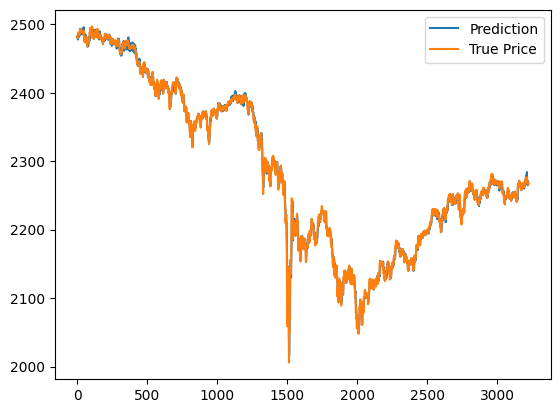

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
calculate_metrics_and_plot(svr_model, 10)

In [142]:
from sklearn.svm import SVR

# Initialize SVR with RBF kernel
svr_original = SVR(kernel='rbf', epsilon=0.088)

# Train the SVR model
svr_original.fit(X_train_features, y_train)

SVR(epsilon=0.088)

Mean Squared Error: 33.56385228104621
R² Score: 0.997622726291456


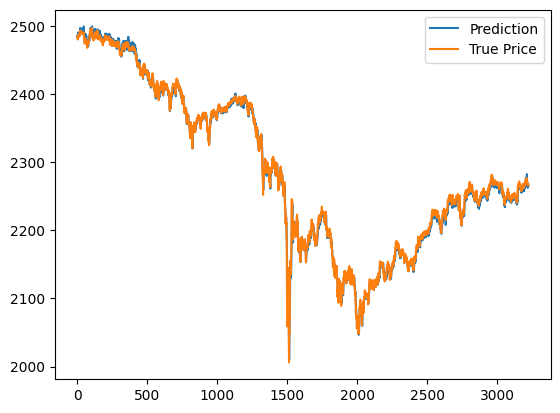

In [143]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
calculate_metrics_and_plot(svr_original, 10)